### Importing packages

In [4]:
import sys 
sys.path.append("C:/Users/levyb/Documents/Masters Data Science - 2nd Year/deepHedgingRL")
import gymnasium as gym
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import tensorflow as tf
from src.pricing.asset_price_process import GBM
from src.pricing.option_price_process import BSM
from src.custom_environments.HedgeEnv_DQN import env_hedging_dqn
from torch import nn


### Setting Up Environment, Asset Price model, and Option Pricing Model

In [6]:
mu = 0
dt = 1/5
T = 10
num_steps = int(T/dt)
s_0 = float(100)
strike_price = s_0
sigma = 0.01
r = 0

def cost(delta_h, multiplier):
    TickSize = 0.1
    return multiplier * TickSize * (np.abs(delta_h) + 0.01 * delta_h**2)


apm = GBM(mu=mu, dt=dt, s_0=s_0, sigma=sigma)
opm = BSM(strike_price=strike_price, risk_free_interest_rate=r, volatility=sigma, T=T, dt=dt)


env = env_hedging_dqn(asset_price_model=apm, dt=dt, T=T, num_steps=num_steps, cost_multiplier = 0, tick_size=0.01,
                     L=1, strike_price=strike_price, integer_holdings=True, initial_holding=0, mode="PL", shares_per_contract=100,
                  option_price_model=opm)



### DQN Agent using StableBaselines 

In [12]:
from stable_baselines3 import DQN
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.dqn.policies import DQNPolicy
from stable_baselines3.common.utils import get_schedule_fn
import os

# Custom Feature Extractor with LSTM
class CustomFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 201):
        super(CustomFeatureExtractor, self).__init__(observation_space, features_dim)
        
        # Assuming the input is a 1D vector, reshape it to (batch_size, sequence_length, features)
        input_dim = observation_space.shape[0]

        self.lstm = nn.LSTM(input_dim, 128, batch_first=True)
        self.fc_net = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, features_dim),
            nn.ReLU(),
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        # Reshape the input to add a sequence length of 1
        observations = observations.unsqueeze(1)
        lstm_out, _ = self.lstm(observations)
        # Use the output of the last time step
        last_timestep_output = lstm_out[:, -1, :]
        return self.fc_net(last_timestep_output)

# Custom DQN Policy
class CustomDQNPolicy(DQNPolicy):
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Discrete,
        lr_schedule,
        net_arch=None,
        activation_fn=nn.ReLU,
        features_extractor_class=CustomFeatureExtractor,
        features_extractor_kwargs=None,
        normalize_images=False,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs=None,
    ):
        super(CustomDQNPolicy, self).__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch=net_arch,
            activation_fn=activation_fn,
            features_extractor_class=features_extractor_class,
            features_extractor_kwargs=features_extractor_kwargs,
            normalize_images=normalize_images,
            optimizer_class=optimizer_class,
            optimizer_kwargs=optimizer_kwargs,
        )

# # Learning rate schedule
    
# lr_schedule = get_schedule_fn(1e-4)

# from stable_baselines3.common.callbacks import BaseCallback

# class RewardCallback(BaseCallback):
#     def __init__(self, check_freq: int, verbose=1):
#         super(RewardCallback, self).__init__(verbose)
#         self.check_freq = check_freq
#         self.rewards = []

#     def _on_step(self) -> bool:
#         # Save the reward for this step
#         reward = self.locals["rewards"][0]  # Access the current reward
#         if self.n_calls % self.check_freq == 0:
#             self.rewards.append(reward)  # Log rewards at each check frequency
#         return True

# # Usage
# callback = RewardCallback(check_freq=1000, verbose=1)

# models_dir = "models/DQN"
# logdir = "logs"

# if not os.path.exists(models_dir):
#     os.makedirs(models_dir)

# if not os.path.exists(logdir):
#     os.makedirs(logdir)

# model_DQN = DQN(policy= CustomDQNPolicy, 
#     env=env,
#     learning_rate=lr_schedule,
#     verbose=1,
#     gamma= 0.85, 
#     batch_size=32,
#     tensorboard_log= logdir)

# TIMESTEPS = 3000000
# model_DQN.learn(total_timesteps= TIMESTEPS, reset_num_timesteps= False, tb_log_name="DQN", callback= callback)
# model_DQN.save(f"{models_dir}/{TIMESTEPS}")


In [1]:
custom_objects = {"policy_class": CustomDQNPolicy}
model = DQN.load("C:/Users/levyb/Documents/Masters Data Science - 2nd Year/deepHedgingRL/models/DQN/du/DQN_0/3000000.zip", custom_objects= custom_objects)

num_episodes = 1

for episode in range(num_episodes): 
    state = env.reset(seed =2024)
    done = False
    cum_option_pnl = 0
    cum_stock_pnl = 0
    cum_cost_pnl = 0
    option_pnls = [0]
    stock_pnls = [0]
    cost_pnls = [0]
    total_pnl = [0]
    stock_pos_shares =[-round(state[0][4], 2)]
    delta_pos_shares = [-round(state[0][4], 2)]
    
    while not done:
        current_holdings, current_asset_price, current_ttm, current_option_value, current_delta = env.get_state()
        delta_action =  -round(current_delta, 2)
        action, _states = model.predict(env.get_state(), deterministic = True)
        next_state, reward, done,done,  info = env.step(action)
        next_holdings, next_asset_price, next_ttm, next_option_value, next_delta = next_state
        delta_h =   next_holdings -current_holdings
        option_pnl = next_option_value-current_option_value
        stock_pnl = current_holdings*(next_asset_price -current_asset_price)- cost(delta_h, 0)
        cum_option_pnl += option_pnl
        cum_stock_pnl += stock_pnl
        cum_cost_pnl += cost(delta_h, 0)

        option_pnls.append(cum_option_pnl)
        stock_pnls.append(cum_stock_pnl)
        cost_pnls.append(cum_cost_pnl)
        total_pnl.append(cum_option_pnl+cum_stock_pnl)
        stock_pos_shares.append(next_holdings)
        delta_pos_shares.append(delta_action)

        if done:
            state = env.reset()

    time_axis = np.linspace(0, num_steps, num_steps + 1)
    plt.figure(figsize=(12, 8))
    plt.plot(time_axis, stock_pnls, label='Stock P&L', color='green', linestyle='-')
    plt.plot(time_axis, option_pnls, label='Option P&L', color='red', linestyle='--')
    #plt.plot(time_axis, cost_pnls, label='Cost P&L', color='magenta', linestyle='--')
    plt.plot(time_axis, total_pnl, label='Total P&L', color='black', linestyle='-.')
    plt.plot(time_axis, stock_pos_shares, label='Stock Position Shares', color='blue', linestyle=':')
    plt.plot(time_axis, delta_pos_shares, label='Delta Position Shares', color='orange', linestyle='--')

    # Add labels, title, and legend
    plt.xlabel('Timestep (D * T)', fontsize=14)
    plt.ylabel('Value (Dollars or Shares)', fontsize=14)
    plt.title('Cumulative P&L and Positions Over Time Cost Multiplier 0', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.show()

NameError: name 'CustomDQNPolicy' is not defined

In [ ]:
from scipy.ndimage import gaussian_filter1d

# Calculate moving average to smooth the curve
window_size = 100 # Adjust the window size as needed
smoothed_rewards = np.convolve(callback.rewards, np.ones(window_size)/window_size, mode='valid')

# Alternatively, you can use Gaussian smoothing for more flexible control:
# smoothed_rewards = gaussian_filter1d(callback.rewards, sigma=2)

# Adjust train_data_point to match the length of smoothed_rewards
train_data_point = np.arange(len(smoothed_rewards)) * callback.check_freq

plt.figure(figsize=(10, 6))
plt.plot(train_data_point, smoothed_rewards, label='Reward', color='green')
plt.xlabel('Timesteps', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.title('Convergence of DQN - Reward Over Training', fontsize=16)
plt.legend(loc='best')
plt.grid(True)
# plt.savefig("DQN_Convergence_3000000.png")
plt.show()


c:\Users\levyb\Deep Hedging RL\DRL_Kolm\option_price_process.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  d_1 = (np.log(asset_price / self.strike_price) + (self.risk_free_interest_rate + self.volatility**2 / 2)
C:\Users\levyb\AppData\Local\Temp\ipykernel_23920\3761800070.py:71: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cost_pnls_reinf, label='Policy: reinf', shade=True)
C:\Users\levyb\AppData\Local\Temp\ipykernel_23920\3761800070.py:72: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cost_pnls_dh, label='Policy: $\delta_{DH}$', shade=True)
C:\Users\levyb\AppData\Local\Temp\ipykernel_23920\3761800070.py:80: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in

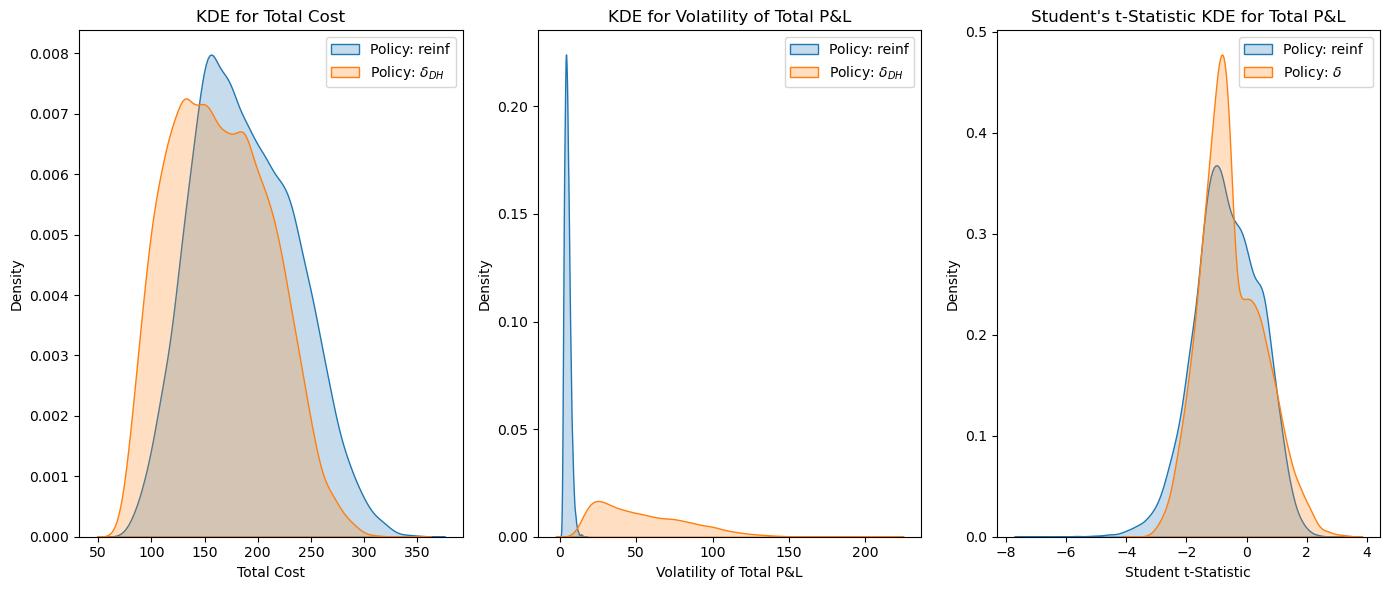

In [79]:
def student_t_statistic(data):
    n = len(data)
    sample_mean = np.mean(data)
    sample_std = np.std(data, ddof=1)
    t_statistic = sample_mean / (sample_std / np.sqrt(n))
    return t_statistic
    

# Getting kernel density estimates for cost and volatility 
num_episodes = 1
cost_pnls_dh= []
cost_pnls_dqn = []
total_pnls_vol_dh =[]
total_pnls_vol_dqn = []
t_stat_pnls_dh = []
t_stat_pnls_dqn = []

for episode in range(num_episodes): 
    state = env.reset()
    done = False
    deltas = [0]
    samp_cost_pnl_dh = 0
    samp_cost_pnl_dqn = 0

    total_pnl_dqn = 0
    total_pnl_dh = 0
    samp_total_pnl_dh = []
    samp_total_pnl_dqn = [] 

    while not done:
        current_holdings, current_asset_price, current_ttm, current_option_price, current_delta = env.get_state()
        delta_holding = -100 * round(current_delta, 2)
        delta_h_dh= delta_holding - deltas[-1]
        deltas.append(delta_holding)

        action, _states = model.predict(env.get_state(), deterministic = True)
        next_state, reward, done, done,  info = env.step(action-0)
        next_holdings, next_asset_price, next_ttm, next_option_price, next_delta = next_state
        delta_h_dqn =  next_holdings -current_holdings

        samp_cost_pnl_dh += cost(delta_h_dh, 5)
        samp_cost_pnl_dqn += cost(delta_h_dqn, 5)

        total_pnl_dqn += ((100*(next_option_price-current_option_price)) + (-current_holdings*(next_asset_price -current_asset_price)- cost(delta_h_dqn, 5)))/100
        total_pnl_dh += ((100*(next_option_price-current_option_price)) + (deltas[-2]*(next_asset_price -current_asset_price)- cost(delta_h_dh, 5)))/100
        samp_total_pnl_dqn.append(total_pnl_dqn)
        samp_total_pnl_dh.append(total_pnl_dh)
        
        if done:
            vol_dqn = np.std(samp_total_pnl_dqn)
            vol_dh = np.std(samp_total_pnl_dh)

            student_t_dqn = student_t_statistic(samp_total_pnl_dqn)
            student_t_dh = student_t_statistic(samp_total_pnl_dh)

            cost_pnls_dqn.append(samp_cost_pnl_dqn)
            cost_pnls_dh.append(samp_cost_pnl_dh)
            total_pnls_vol_dqn.append(vol_dqn)
            total_pnls_vol_dh.append(vol_dh)
            t_stat_pnls_dqn.append(student_t_dqn)
            t_stat_pnls_dh.append(student_t_dh)
            state = env.reset()

from scipy import stats
import seaborn as sns

# Plot kernel density estimates for total cost
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.kdeplot(cost_pnls_dqn, label='Policy: reinf', shade=True)
sns.kdeplot(cost_pnls_dh, label='Policy: $\delta_{DH}$', shade=True)
plt.title('KDE for Total Cost')
plt.xlabel('Total Cost')
plt.ylabel('Density')
plt.legend()

# Plot kernel density estimates for volatility of total P&L
plt.subplot(1, 3, 2)
sns.kdeplot(total_pnls_vol_dqn, label='Policy: reinf', shade=True)
sns.kdeplot(total_pnls_vol_dh, label='Policy: $\delta_{DH}$', shade=True)
plt.title('KDE for Volatility of Total P&L')
plt.xlabel('Volatility of Total P&L')
plt.ylabel('Density')
plt.legend()

# Plot KDE for Student's t-statistic of Total P&L
plt.subplot(1, 3, 3)
sns.kdeplot(t_stat_pnls_dqn, label='Policy: reinf ', shade=True)
sns.kdeplot(t_stat_pnls_dh, label='Policy: $\delta$', shade=True)
plt.title("Student's t-Statistic KDE for Total P&L")
plt.xlabel('Student t-Statistic')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()

# plt.savefig("C:/Users/levyb/Documents/Masters Data Science - 2nd Year/deepHedgingRL/notebooks/models/DQN")
plt.show()
